<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">

**Привет!** 👋
    
К сожалению, не вижу в тикете, как тебя зовут.

Меня зовут Алексей Манелюк, я буду проверять твой проект. В Яндекс Практикуме принято общаться на "ты" 😉, но если некомфортно - скажи и перейдем на "Вы".

Моя цель - не указать на ошибки, а поделиться опытом и помочь в освоении анализа данных.

В тетрадке ты увидишь мои комментарии, пожалуйста, не удаляй, не перемещай и не изменяй их. У комментариев могут быть приписки **V2**, **V3**, **V...**, которые соответствуют каждой версии проверки.

Я буду использовать цветовую разметку:
<p>
<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

Так выделены критические замечания. Без их отработки я не смогу принять проект. </div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>  Комментарий ревьюера ⚠️</b>

Так выделены небольшие замечания или полезные советы. Постарайся учесть их.</div>
<p>
<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Так выделены правильные решения.</div>

Предлагаю работать в диалоге: если что-то дорабатываешь или отвечаешь на мой комментарий - пиши об этом. Мне будет удобней, если ты выделишь свои комментарии:
<p>
<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Здесь исправил.</div>

Все это поможет мне быстрее принять твой проект.</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Написать свой комментарий можно, скопировав этот блок в ячейку Markdown.</div>

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

<s>В самом начале проекта обязательно нужно добавлять название, цели исследования, описание данных и план работы.

А в конце каждого шага (раздела) работы стоит написать промежуточный вывод.

Как правильно оформить проект ты можешь прочитать в материалах курса:

`Полезные инструкции для учёбы - Оформление проекта - Рекомендации по выполнению проектов`
</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Привет, Меня зовут Артем Русаков.</div>

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ❌</b>

<s>Артем, привет! Добавь пожалуйста описание проекта.
</div>

# Сервис аренды самокатов GoFast
#### Описание проекта
Анализ популярного сервиса аренды самокатов GoFast.  
Объектом исследования являются данные о некоторых пользователях из нескольких городов, а также об их поездках. 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.   
Сервисом можно пользоваться: c подпиской и без.
Тарифы подписок указаны в файле subscriptions_go.csv
  
  **План работ:**  

1 Загрузка и ознакомления с данными
  
  2 Предобработка данных(выявление пропусков, дубликатов итд)
  
  3 Анализ данных(нахождение зависимостей между данными, наличие аномалий, параметры распределений данных)
  
  4 Объединение данных в одну таблицу
  
  5 Проверка гипотез которые могут помочь бизнесу вырасти.
  
  6 Проверка вероятностного эффекта от проведения акций
  
  7 Общий вывод


<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V3 ✔️</b>

Отлично. 👌</div>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial, sqrt

#### Шаг 1. Загрузка данных

In [2]:
с
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_subscribes = pd.read_csv('/datasets/subscriptions_go.csv')

Выведем первые 5 строк для ознакомления с данными каждого датафрейма.

In [3]:
display(data_users.head())
display(data_rides.head())
display(data_subscribes.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

<s>Для вывода таблиц в Jupyter Notebook, стоит использовать функцию `display()` вместо `print()`.

А если вывод таблицы в последней строке ячейки Jupyter Notebook, можно вообще эти функции не использовать.</div>

Общая гистограмма для всех числовых столбцов таблиц

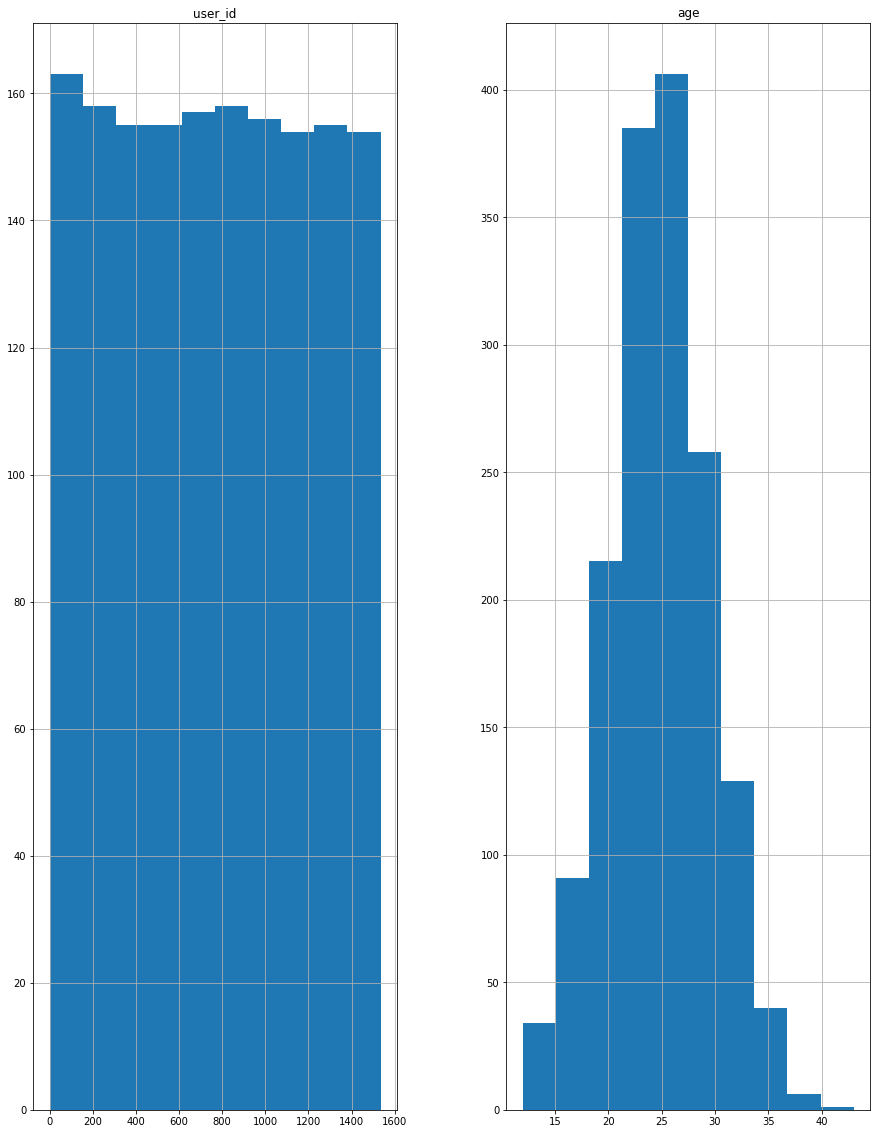

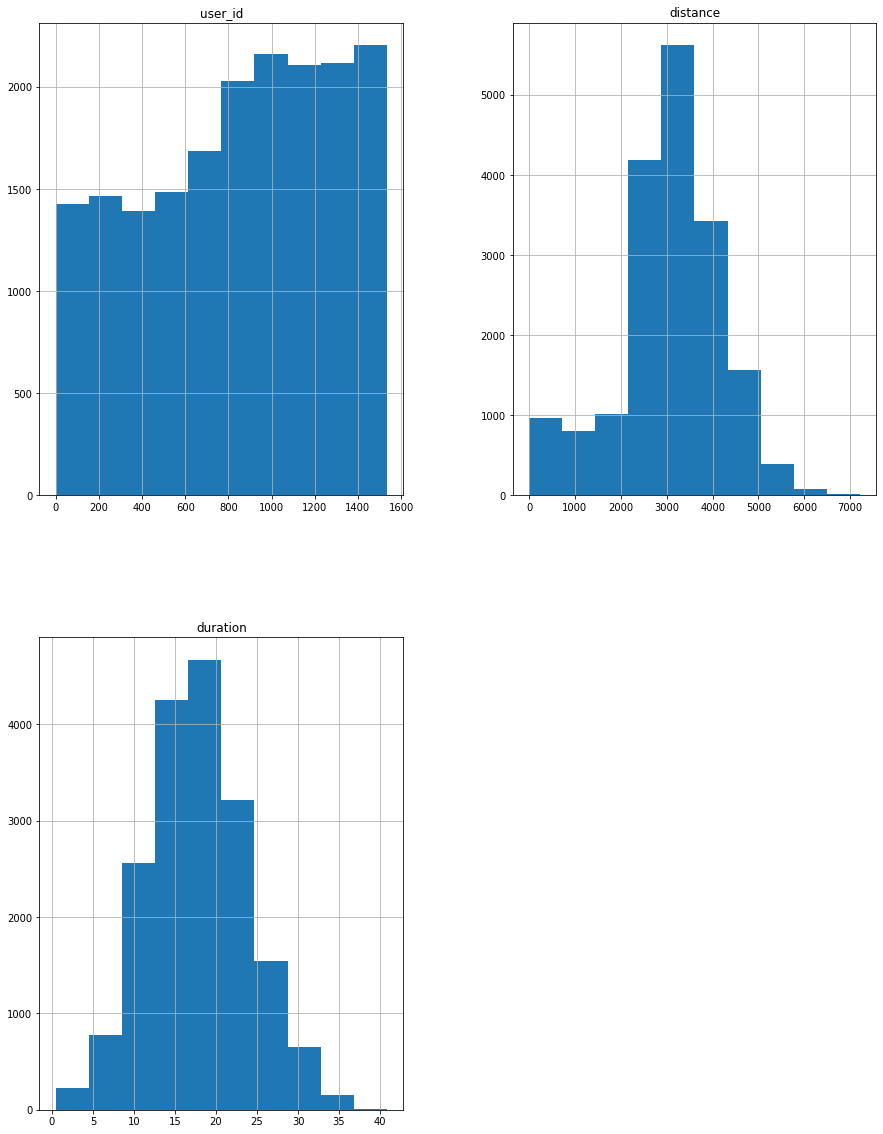

In [4]:
data_users.hist(figsize=(15, 20))
data_rides.hist(figsize=(15, 20))
plt.show()

In [5]:
data_users.info()
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Данные загружены верно, получена общая информация о датафреймах. 🚀</div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

<s>Какой можно сделать промежуточный вывод по первичному знакомству с данными?</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

По типу данных столбцы первых двух датафреймов делятся:  
-Категориальные: name, city, subscription_type.  
-Количественные: age, distance, duration, date.

В датафрейме subscription содержится информация по тарифам с подпиской и без.</div>

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V2 ✔️</b>

Супер! Можно также добавить информацию о размерах датафреймов, какие есть проблемы, набросать план по предобработке.</div>

#### Шаг 2. Предобработка данных

Приведем столбец date к типу даты pandas

In [6]:
data_rides['date'] =  pd.to_datetime(data_rides['date'], format='%Y-%m-%d')

Создадим дополнительный столбец с номером месяца 

In [7]:
data_rides['month'] = data_rides['date'].dt.month
#def make_month(row):
#    row[4] = row[3].month
#    return row
#data_rides = data_rides.apply(make_month,axis=1)

display(data_rides.head())


print(f"Данные представлены за период от {data_rides['date'].dt.to_period('M').min()} до {data_rides['date'].dt.to_period('M').max()}")

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Данные представлены за период от 2021-01 до 2021-12


<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>
    
<s>Вытащить месяц из даты можно так:
    
```py
df['month'] = df['date'].dt.month
```

На этом этапе также можно проверить за какой период у нас данные.</div>

Проверим пропуски в данных data_users и data_rides

In [8]:
print(data_users.isna().sum())
print(data_rides.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


<div class="alert-info" style="padding: 20px; border-radius: 10px">
Проверим дубликаты в датафреймах data_users и data_rides
    </div>

In [9]:
display(data_users.duplicated().value_counts())
display(data_rides.duplicated().value_counts())

False    1534
True       31
dtype: int64

False    18068
dtype: int64

<div class="alert-info" style="padding: 20px; border-radius: 10px">
В data_users содержится 31 явных дубликатов, удалим их.
</div>

In [10]:
data_users.drop_duplicates(inplace = True)
display(data_users.duplicated().value_counts())

False    1534
dtype: int64

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

<s>А почему ты считаешь, что в данных были дубликаты? Перед удалением, хорошо бы удостовериться что дубликаты присутствуют.</div>

<div class="alert-danger"  style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

<s>Чтобы удалить дубликаты, нужно перезаписать датафрейм или использовать параметр `inplace = True` в методе `drop_duplicates()`
    

</div>

In [11]:
# Код ревьюера
data_users.duplicated().sum()

0

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Дубликаты обработаны правильно.</div>

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

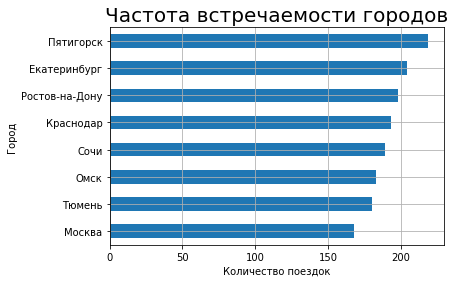

In [12]:
data_users_city = data_users['city'].value_counts()
display(data_users_city)
data_users_city.sort_values(ascending=True).plot(kind='barh',grid=True, legend = False)
plt.title('Частота встречаемости городов', fontsize= 20)
plt.ylabel('Город')
plt.xlabel('Количество поездок')
pd.options.mode.chained_assignment = None


<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

<s>Этот график можно немного доработать:

- отсортировать категории по убыванию
- добавить название

Также можно либо развернуть график на 90 градусов (тип графика `barh`) или развернуть подписи к оси Х (параметром `rot=`)</div>

Самый популярный город Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168

##### Соотношение пользователей с подпиской и без 

In [13]:
print(data_users['subscription_type'].value_counts())

free     835
ultra    699
Name: subscription_type, dtype: int64


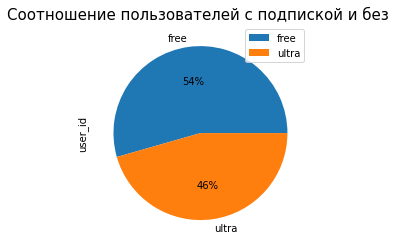

In [14]:
data_users.groupby(['subscription_type']).count().plot(kind='pie', y = 'user_id', autopct='%1.0f%%')
plt.title('Соотношение пользователей с подпиской и без ', fontsize= 15)
plt.show()

Количество пользователей без подписки(835) немного меньше чем с подпиской(699).

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

<s>Не посчитано соотношение пользователей с подпиской и без (в долях или процентах от целого).
</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Добавил проценты на график.</div>

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Теперь всё отлично! 👍</div>

##### Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

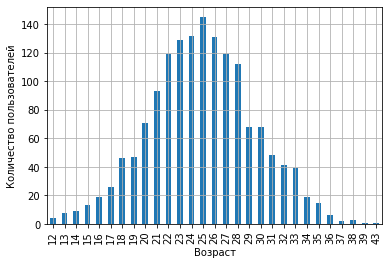

In [15]:
display(data_users['age'].describe())

data_users.pivot_table(index='age', values='user_id', aggfunc=['count']).plot(kind='bar',grid=True, legend = False)
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
pd.options.mode.chained_assignment = None

График принимает вид нормального распределения. Самый распространенный возраст 25 лет.

<div class="alert-warning" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V2 ⚠️</b>

Для визуализации распределения стоит использовать гистограмму. 👇
</div>

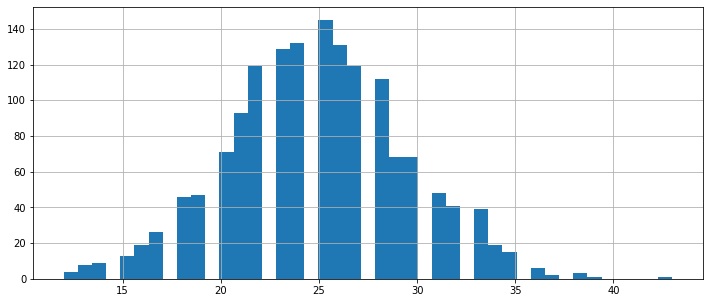

In [16]:
# Код ревьюера
plt.figure(figsize = (12, 5))
data_users['age'].hist(bins = max(data_users['age']))
plt.show()

##### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

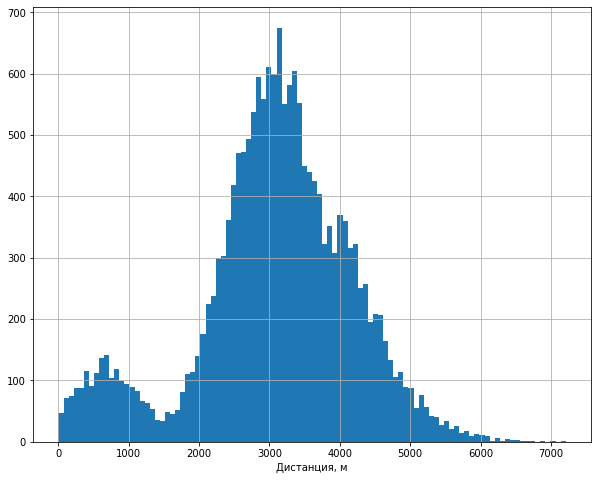

In [17]:
display(data_rides['distance'].describe())
data_rides['distance'].hist(figsize=(10, 8), bins=100)
plt.xlabel('Дистанция, м')
pd.options.mode.chained_assignment = None

Есть небольшая группа пользователей, длительная поездка которых составляет то 1,5км. Скорее всего это расстояние от метро до конечной или начальной точки.
Самое распространенное расстояние около 3км.

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Минимальное расстояние 0.85км. Основной диапазон значений от 2.5км до 3.8км</div>

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V2 ✔️</b>

Да, судя по графику поездки можно поделить на короткие и длинные.</div>


##### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

<AxesSubplot:>

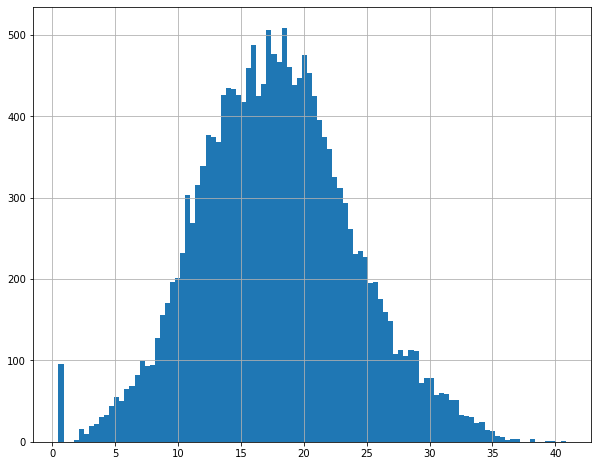

In [18]:
display(data_rides['duration'].describe())
data_rides['duration'].hist(figsize=(10, 8), bins=100)

Есть выброс в околонулевых значениях. Возможно это отмененные поездки. 
<div class="alert-info" style="padding: 20px; border-radius: 10px">
Минимальное значение 0.5мин, возможно это ошибка в данных так как много одинаковых значений, проверим их количество</div>

In [19]:
data_anomaly = data_rides[data_rides['duration'] == 0.5].shape[0]
print(f'Аномалии составляют: {round(data_anomaly/len(data_rides)*100, 2)} % от всей выборки.')

Аномалии составляют: 0.53 % от всей выборки.


<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента V2💎</b>
    
Так как количество аномалий мало относительно всей выборки и плата за эти поездки была списана(что может повлиять на расчет выручки в далбнейшем) удалять эти данные из датафрейма не будем
</div>

In [20]:
#data_rides = data_rides[data_rides['duration'] != 0.5]
#display(data_rides['duration'].describe())
#data_rides['duration'].hist(figsize=(10, 8), bins=100)

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ❌</b>

<s>Я согласен с тобой, что суперкороткие поездки кажутся выбросами. Обратить на это внимание стоит, но удалять - нет. За эти поездки была начислена плата. Дальше мы будем считать выручку по пользователям за месяц и удаление части данных может повлиять на финансовый результат.
</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Среднее время поездок составляет 17мин, максимальное 40 мин, минимальное 0.5 мин
Основной диапазон значений от 13 до 22 мин</div>

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

<s>Стоит более подробно описать все распределения данных: основной диапазон, минимум, максимум, наличие аномалий.

Рассчитать описательные статистики можно с помощью метода `describe()`
</div>

#### Шаг 4. Объединение данных

##### Добавим датафрейм data_rides к data_users

In [21]:
data_merge = data_users.merge(data_rides, on = 'user_id')
data_merge.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


##### Создадим два датафрейма c данными о пользователях без подписки(data_merge_free) и с данными о пользователях с подпиской(data_merge_ultra) на освнове объедененного на предыдущем этапе датафрейма

In [22]:
data_merge_ultra = data_merge.query('subscription_type == "ultra"')
display(data_merge_ultra)
data_merge_free = data_merge.query('subscription_type == "free"')
display(data_merge_free)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10


,user_id,name,age,city,subscription_type,distance,duration,date,month
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [23]:
# Код ревьюера
display(data_merge.shape[0])
display(data_merge_free.shape[0])
data_merge_ultra.shape[0]

18068

11568

6500

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

После объединения данных имеет смысл вывести несколько строк датафрейма, проверить размерность. 
    
Из-за того, что не были удалены дубликаты, объединение прошло не совсем корректно.

</div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ⚠️</b>

<s>Теперь часть данных из объединенного фрейма потерялась. (Из-за удаления аномалий.)

</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента V2💎</b>

Аномалии вернул </div>

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V3 ✔️</b>

Теперь размеры датафреймов корректные.</div>

##### Графики распределения расстояния и времени поездок для пользователей обеих категорий

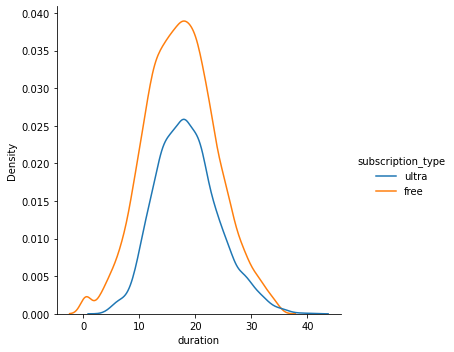

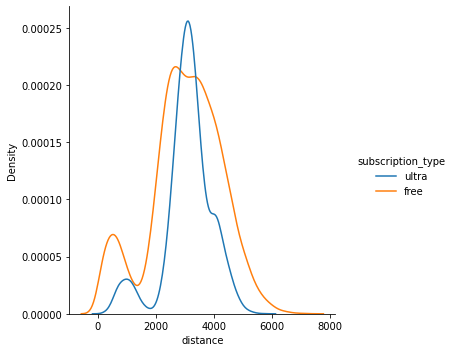

In [24]:
sns.displot(data_merge, x="duration", hue="subscription_type", kind="kde")
sns.displot(data_merge, x="distance", hue="subscription_type", kind="kde")

<div class="alert-danger"  style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

<s>Что можно сказать о сравнении профилей категорий пользователей при пользовании самокатами (расстояние, длительность)? Какие есть различия и сходства?

</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

По времени:
Формы распеделения времени поездок схожи для категорий с подпиской и без, пики графиков находятся в районе 20 мин. Из-за большего количества поездок без подписок, график располагается выше.  
По расстоянию:
График распределения расстояния для пользователей с подпиской имеет более явный пик в районе 3км, это говорит о однотипных по расстоянию поездках. Так же пики значений для пользователей без подписки смещены ближе к 0. </div>


<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Согласен, можно сказать, что профили пользователей обоих подписок похожи.

</div>

#### Шаг 5. Подсчёт выручки

In [25]:
#Округлим до следующего целого числа продолжительность поездок
data_merge['duration']= np.ceil(data_merge['duration'])

#Создадим сводную таблицу с дополнительными столбцами по суммарному расстоянию и времени, кол-ву поездок, типу подписок 
data_total = data_merge.pivot_table(index=['user_id', 'month'], values = ['distance', 'duration', 'name', 'subscription_type'], aggfunc={'distance':'sum', 'duration':'sum', 'name':'count', 'subscription_type': 'min'})
data_total.columns = ['total_distance', 'total_duration','rides_count', 'subscription_type']
data_total = data_total.reset_index()
display(data_total)

#Добавим столбец помесячной стоимости поездок каждого пользователя
def income_func (row):
    if row['subscription_type'] == 'ultra':
        return data_subscribes['minute_price'].values[1]*row['total_duration'] + data_subscribes['subscription_fee'].values[1]
    if row['subscription_type'] == 'free':
        return data_subscribes['minute_price'].values[0]*row['total_duration'] + data_subscribes['start_ride_price'].values[0]*row['rides_count']

data_total['income'] = data_total.apply(income_func, axis=1)  
display(data_total)

,user_id,month,total_distance,total_duration,rides_count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free
11327,1534,8,7622.453034,48.0,2,free
11328,1534,9,4928.173852,23.0,1,free
11329,1534,11,13350.015305,78.0,4,free


,user_id,month,total_distance,total_duration,rides_count,subscription_type,income
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,46.0,2,ultra,475.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,56.0,3,ultra,535.0
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,308.0
11327,1534,8,7622.453034,48.0,2,free,484.0
11328,1534,9,4928.173852,23.0,1,free,234.0
11329,1534,11,13350.015305,78.0,4,free,824.0


In [26]:
data_total.groupby('subscription_type')['income'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: income, dtype: float64

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V3 ✔️</b>

Выручка рассчитана правильно. 👍</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Среднее значение помесячной выручки от пользователей с подпиской выше примерно на 10% </div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ⚠️</b>

<s>Теперь на расчет выручки повлияло удаление аномалий.</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Аномалии вернул </div>

In [27]:
# Код ревьюера
data_total.groupby('subscription_type')['income'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: income, dtype: float64

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

<s>В целом, расчет выручки правильный, но из-за того что не были удалены дубликаты в пользователях, средние значения получились не совсем верные.</s>

Не забывай пожалуйста заканчивать шаг работы промежуточным выводом о том, что было сделано.</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента V2💎</b>

На данном шаге была посчитана выручка:  
    Среднее значение помесячной выручки от пользователей с подпиской составляет 363руб.  
    Среднее значение помесячной выручки от пользователей без подписки составляет 329руб.  
    Среднее значение помесячной выручки от пользователей с подпиской выше примерно на 10%</div>

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

<s>Перед проверкой гипотезы нужно сформулировать нулевую и альтернативную гипотезы.

Это относится к каждому статистическому тесту</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>
    
H0 - пользователи с подпиской тратят на поездку столько же времени что и пользователи без подписки   
    H1 - пользователи с подпиской тратят на поездку больше времени чеми пользователи без подписки 
</div>

In [28]:
ultra_group = data_merge_ultra['duration']
free_group = data_merge_free['duration']
alpha = 0.05
results = st.ttest_ind(ultra_group, free_group, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят в сервисе больше времени на поездку.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Результат проверки гипотезы правильный. 👌</div>

##### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>
  
H0 - пользователи с подпиской проезжают 3130 метров за одну подписку   
    H1 - пользователи с подпиской проезжают за одну поездку расстояние превышающее 3130 метров
</div>

In [29]:
ultra_group_dist = data_merge_ultra['distance']
wear_distance = 3130
alpha = 0.05
results = st.ttest_1samp(ultra_group_dist, wear_distance, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Гипотеза, о том что пользователи с подпиской проезжают больше 3130 метров, не может быть отвергнута, так как p-value равен 92%

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>
  
Пользователи с подпиской проезжают по статистике вероятно больше 3130 метров, тем самым сильнее изнашивают самокаты. 
</div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ⚠️</b>

Приведи пожалуйста свой вывод в соответсвие с формулировкой гипотезы и результатом статистического теста. </div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента V2💎</b>
    
Выборочное среднее дистанции от значения, предполагаемого в H0, находится рядом и удовлетворяет условию в H1 c p-value 92%.
    Из этого следует что пользователи с подпиской вероятнее всего проезжают больше 3130м и тем самым сильнее изнашивают самокаты.
</div>
 

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V3 ⚠️</b>

По итогам теста ты не отвергаешь нулевую гипотезе о равенстве средней дистанции поездки 3130. Это означает, что подписчики не превышают оптимальной дистанции по износу. </div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

Статистический тест проведен правильно. Но как можно сформулировать вывод исходя из задачи поставленной бизнесом: изнашивают ли подписчики сильнее самокаты? </div>

##### Гипотеза о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>
  
H0 - пользователи с подпиской тратят в месяц столько же что и пользователи без подписки    
H1 - пользователи с подпиской тратят в месяц больше чем пользователи без подписки
</div>

In [30]:
ultra_group_income = data_total.query('subscription_type == "ultra"')['income']
free_group_income = data_total.query('subscription_type == "free"')['income']
alpha = 0.05
results = st.ttest_ind(ultra_group_income, free_group_income, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят в сервисе меньше денег на поездку в месяц.

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V2 ✔️</b>

Результат проверки гипотезы - правильный.
</div>

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?


Необходима проверка левосторонней альтернативной гипотезы о равенстве средних для зависимых (парных) выборок(истинное среднее генеральной совокупности до изменения должно быть меньше, чем истинное среднее генеральной совокупности после изменения).

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Верно, чтобы проверить, значительно ли уменьшилось количество обращений в техподдержку после обновления серверов, можно использовать t-тест для парных выборок.

</div>

#### Шаг 7. Распределения

##### Акция с раздачей промокодов

0.05043959099661155


<BarContainer object of 857 artists>

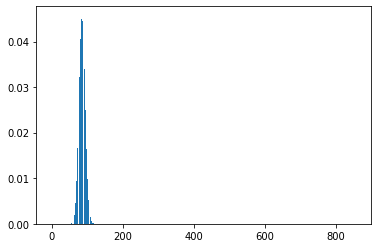

In [31]:
n = 856
p = 0.1 

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

result = 1 - distr.cdf(100)
print(result)

distr1 = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr1.append(prob)
    
plt.bar(range(0, n + 1), distr1)

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

Поясни пожалуйста, откуда сразу берется число 856 в параметрах распределения, которые ты задаешь?</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>
  
n подбирал таким образом чтобы вероятность невыполнения составляла 5%
</div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ⚠️</b>

Для решения задачи не нужно указывать количество промокодов напрямую, потому что оно зависит от заданных вероятности и уровня значимости (например, 5%).

Можно использовать функцию биномиального распределения, где в качестве параметров задать количество клиентов, которые могут продлить подписку (то есть, клиенты, которым можно отправить промокод), вероятность продления подписки после использования промокода (10%), и число клиентов, которое должно продлить подписку (100).

Затем нужно использовать цикл и посчитать вероятность, пока она не достигнет заданной. Для расчета вероятности можно использовать метод cdf().

Таким образом, после нескольких итераций цикла можно получить количество промокодов, которое нужно разослать, чтобы вероятность не выполнения плана была примерно 5%

</div>

Необходимо раздать 856 промокодов для вероятности невыполнения плана в 5%

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении.

In [32]:
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

result = distr.cdf(399500)
print(result)


0.15371708296369768


Вероятность что уведомление откроют 399,5 тыс пользователей, составляет 15%

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Здесь результат верный! 👍

</div>

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

<s>Не хватает общего вывода по проекту.

Общий вывод - важный элемент работы. Его нужно сформулировать, взяв основные результаты из всех шагов проекта. Начать нужно с того, с какими данными мы работали, сформулировать все основные результаты исследования, дать аргументированный ответ на главный вопрос исследования: являются ли подписчики более выгодными для компании?

Заказчик, зачастую, читает только общий вывод исследования - поэтому он должен быть максимально информативным.</div>

<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">

<b>Общий комментарий ревьюера:</b>

Проделана большая работа над проектом. Но нужно кое-что поправить, чтобы я его принял.

Есть несколько критических замечаний:
    
- по обработке дубликатов
- по оформлению работы: вводная часть и промежуточные выводы по разделам
- по расчету соотношения пользователей с подпиской и без
- по описанию распределений возраста пользователей, расстояния и времени поездки
- по сравнению расстояния и времени поездок разных категорий пользователей
- по формулировке нулевой и альтернативной гипотез
- по общему выводу

Также, постарайся отработать желтые комментарии.

Буду ждать твой доработанный проект. ⌛️</div>


#### Общий вывод 
В ходе работы над проектом исследованы три датафрейма о _пользователях, поездках и подписках._  
    В датафрейме subscription содержится информация по тарифам с подпиской и без.  
    Количество записей по поездкам равно 18068.  
    Данные представлены за период от января до декабря 2021 года     
    **На стадии предобработки было выявлено:**  
    -Пропусков в данных не обнаружено.  
    -В датафрейме с пользователями содержалось 31 явных дубликатов, которые впоследствии мы удалили.  
    -Так же обнаружена аномалия в данных. 95 записей были с продолжитьельностью 30 сек. Эти записи были удалены, так как составляли 0.5% от всей всей выборки и не повляили бы на объективность проверки гипотез.  
    **На шаге исследования было выявлено:**  
    -Самый популярный город Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168  
    -Количество пользователей без подписки составляет 835 человек(54%), а пользователей с подпиской 699 человек(46%)  
    -Самый распространенный возраст пользователей 25 лет.  
    -Минимальное расстояние поездки 0.85км. Основной диапазон значений от 2.5км до 3.8км  
    -Среднее время поездок составляет 17мин, максимальное 40 мин, минимальное 2 мин.Основной диапазон значений от 13 до 22 мин  
    **Построены графики распределения расстояния и времени поездок для пользователей обеих категорий:**  
    -Формы распеделения времени поездок схожи для категорий с подпиской и без, пики графиков находятся в районе 20 мин. Из-за большего количества поездок без подписок, график располагается выше.  
    -График распределения расстояния для пользователей с подпиской имеет более явный пик в районе 3км, это говорит о однотипных по расстоянию поездках.  
    **Подсчитана выручка:**  
    Среднее значение помесячной выручки от пользователей с подпиской составляет 363руб.  
    Среднее значение помесячной выручки от пользователей без подписки составляет 329руб.  
    Среднее значение помесячной выручки от пользователей с подпиской выше примерно на 10%  
    **На шаге проверки гипотез пришли к выводам:**  
    1)Есть основания говорить, что пользователи с подпиской тратят в сервисе больше времени на поездку.  
    2)Пользователи с подпиской проезжают по статистике вероятно больше 3130 метров, тем самым сильнее изнашивают самокаты.  
    3)Есть основания говорить, что пользователи с подпиской тратят в сервисе меньше денег на поездку в месяц.  
    Для проведения акции с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку с вероятностью успеха в 95% необходимо раздать 856 промокодов.  
    Вероятность того, что 1 млн разосланных push-уведомлений, разосланных отделом маркетинга, откроют не более 399,5 тыс. пользователей составляет 15%.    

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ⚠️</b>

В целом, хороший вывод. Я бы разделил его на абзацы для легкости чтения. Также, можно выделить **самые важные моменты** с помощью форматирования.

Вот ссылочка, которая поможет отформатировать текст в ячейке Markdown

https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd</div>

<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">

<b>Общий комментарий ревьюера V2:</b>

Спасибо, что дорабатываешь проект.

У меня остались критические замечания:
    
- по описанию исследования (вводная часть)
- по удалению части данных

Также, посмотри новые желтые комментарии V2.

Уверен, ты быстро всё поправишь. ⏱</div>

<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">

<b>Общий комментарий ревьюера V3</b>

Спасибо, что доработал проект! Критических замечаний больше нет, получилась хорошая работа.

Успехов в дальнейшем обучении! 🏆

</div>